# 04 — Dimensionality Reduction

This notebook applies dimensionality reduction to visualize the high-dimensional
feature space in 2D and understand the structure of HAR data:
1. **PCA** — linear projection preserving maximum variance
2. **t-SNE** — non-linear embedding preserving local structure
3. Comparison and interpretation

---

## 4.1 — Imports and Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set_theme(style='whitegrid', palette='deep', font_scale=1.1)

DATA_DIR = Path('processed_data')

# Load engineered features
X_train = pd.read_csv(DATA_DIR / 'X_train_features_selected.csv')
X_test  = pd.read_csv(DATA_DIR / 'X_test_features_selected.csv')
y_train = np.load(DATA_DIR / 'y_train.npy')
y_test  = np.load(DATA_DIR / 'y_test.npy')

with open(DATA_DIR / 'metadata.json') as f:
    meta = json.load(f)
ACTIVITY_MAP = {int(k): v for k, v in meta['activity_map'].items()}

print(f'X_train: {X_train.shape}  |  X_test: {X_test.shape}')

# Subsample for t-SNE speed (use up to 10,000 points)
MAX_SAMPLES = 10000
if len(X_train) > MAX_SAMPLES:
    idx = np.random.choice(len(X_train), MAX_SAMPLES, replace=False)
    X_sub = X_train.iloc[idx].values
    y_sub = y_train[idx]
    print(f'Subsampled to {MAX_SAMPLES} points for visualization.')
else:
    X_sub = X_train.values
    y_sub = y_train

X_train: (81935, 100)  |  X_test: (28570, 100)
Subsampled to 10000 points for visualization.


## 4.2 — PCA (Principal Component Analysis)

PCA finds orthogonal directions of maximum variance. It is fast, deterministic,
and reveals how much variance is captured by the top components.

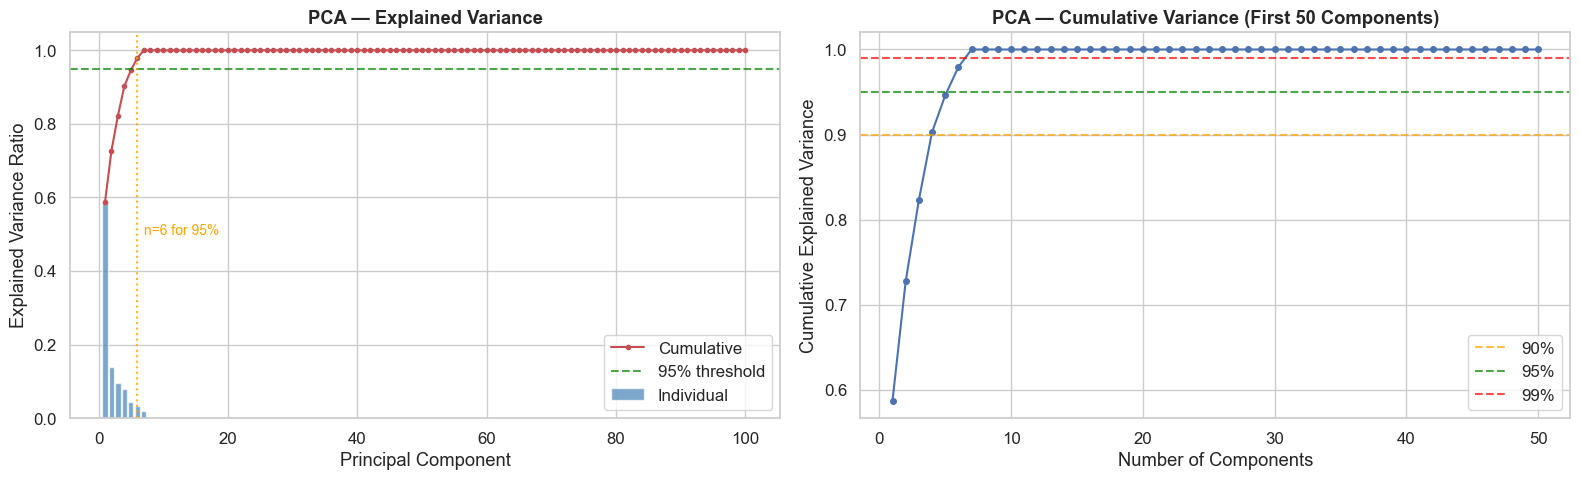


Components for 90% variance: 4
Components for 95% variance: 6
Components for 99% variance: 7


In [2]:
# Fit PCA on all components to see explained variance
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_train.values)

explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Scree plot
axes[0].bar(range(1, len(explained_var)+1), explained_var, alpha=0.7, color='steelblue', label='Individual')
axes[0].plot(range(1, len(cumulative_var)+1), cumulative_var, 'r-o', markersize=3, label='Cumulative')
axes[0].axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='95% threshold')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA — Explained Variance', fontweight='bold')
axes[0].legend()

# Find number of components for 95% variance
n_95 = np.argmax(cumulative_var >= 0.95) + 1
axes[0].axvline(x=n_95, color='orange', linestyle=':', alpha=0.8)
axes[0].text(n_95 + 1, 0.5, f'n={n_95} for 95%', fontsize=10, color='orange')

# Cumulative zoom
axes[1].plot(range(1, min(51, len(cumulative_var)+1)), cumulative_var[:50], 'b-o', markersize=4)
axes[1].axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90%')
axes[1].axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='95%')
axes[1].axhline(y=0.99, color='red', linestyle='--', alpha=0.7, label='99%')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('PCA — Cumulative Variance (First 50 Components)', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('pca_explained_variance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nComponents for 90% variance: {np.argmax(cumulative_var >= 0.90) + 1}')
print(f'Components for 95% variance: {n_95}')
print(f'Components for 99% variance: {np.argmax(cumulative_var >= 0.99) + 1}')

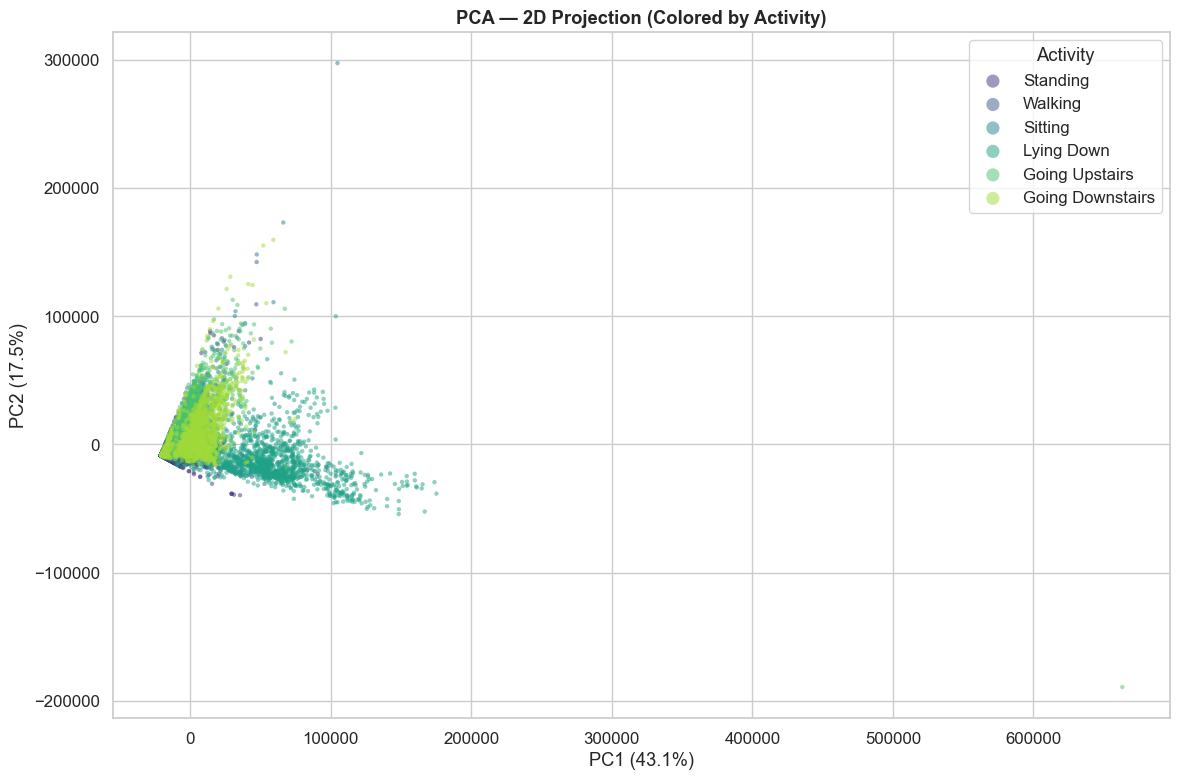

In [3]:
# 2D PCA projection
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca_2d.fit_transform(X_sub)

fig, ax = plt.subplots(figsize=(12, 8))
scatter_colors = sns.color_palette('viridis', n_colors=6)

for label in sorted(np.unique(y_sub)):
    mask = y_sub == label
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=[scatter_colors[label]], label=ACTIVITY_MAP.get(label, str(label)),
               alpha=0.5, s=10, edgecolors='none')

ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA — 2D Projection (Colored by Activity)', fontweight='bold')
ax.legend(title='Activity', markerscale=3)
plt.tight_layout()
plt.savefig('pca_2d.png', dpi=150, bbox_inches='tight')
plt.show()

**PCA Observations:**
- A relatively small number of components captures most of the variance,
  suggesting significant redundancy among our 100 features.
- The 2D projection shows partial separation of activities: static activities
  (standing, sitting, lying) often overlap, while dynamic activities (walking,
  stairs) form more distinct clusters.
- PCA alone is not sufficient for perfect separation — non-linear methods may help.

---

## 4.3 — t-SNE Visualization

t-SNE is a non-linear dimensionality reduction technique that preserves local
neighborhoods. It is excellent for visualization but cannot be used for
downstream prediction (no `transform` for new data).

Running t-SNE with perplexity=15...
Running t-SNE with perplexity=30...
Running t-SNE with perplexity=50...


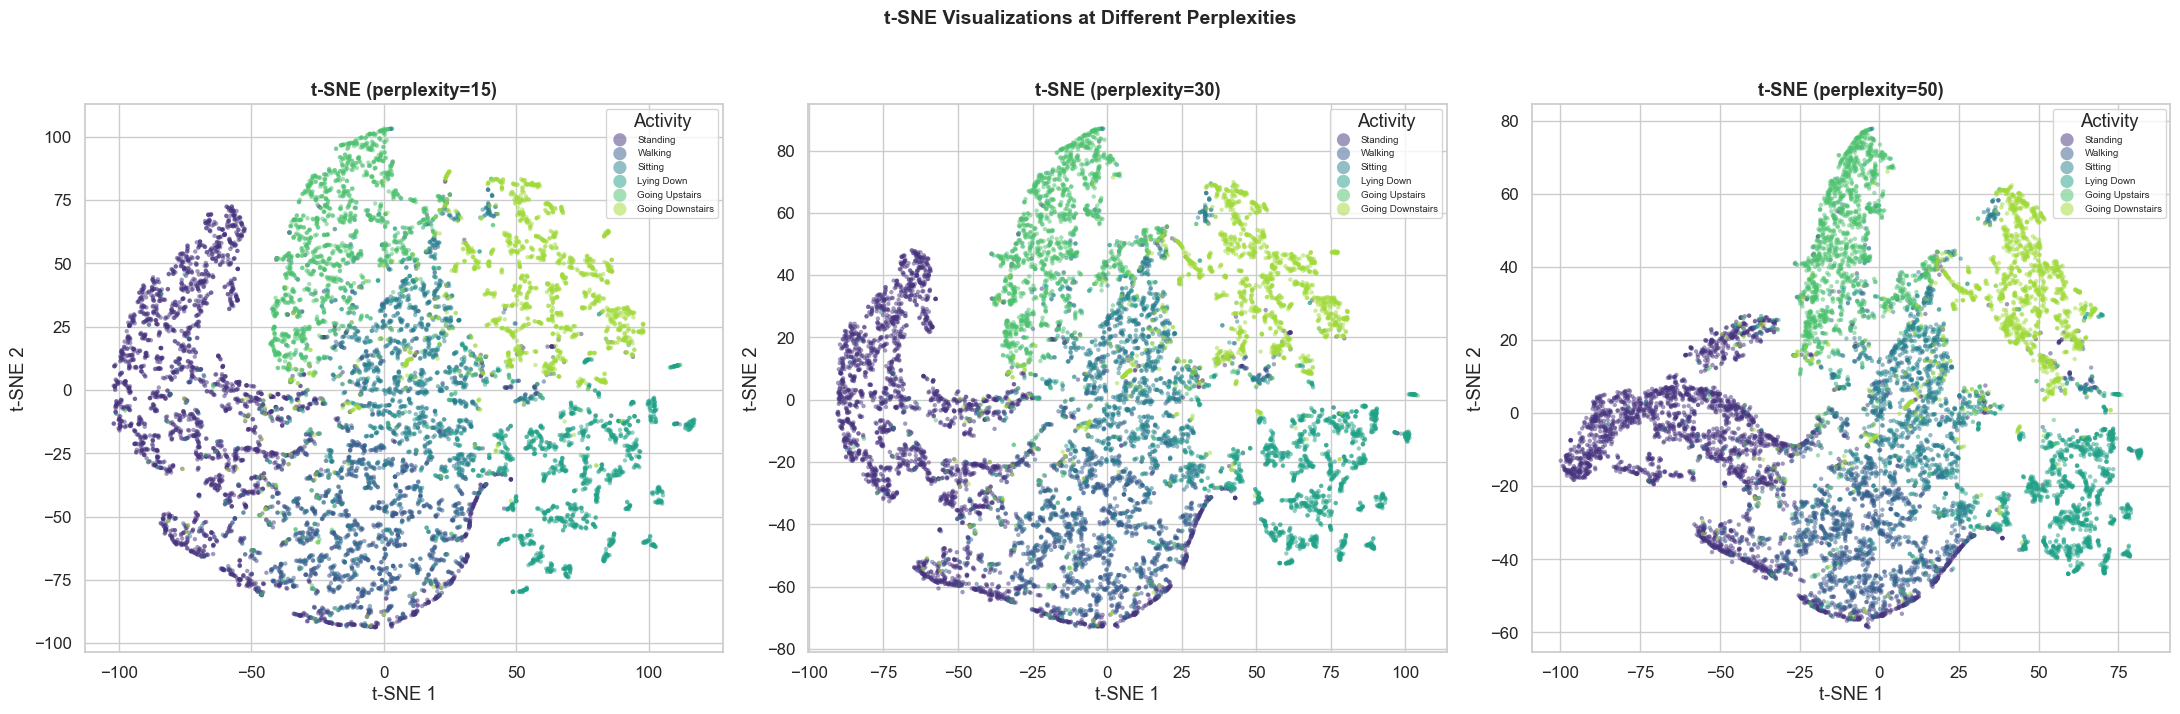

Done.


In [6]:
# t-SNE with different perplexity values
perplexities = [15, 30, 50]

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

for ax, perp in zip(axes, perplexities):
    print(f'Running t-SNE with perplexity={perp}...')
    tsne = TSNE(n_components=2, perplexity=perp, max_iter=1000,
                random_state=RANDOM_STATE, learning_rate='auto', init='pca')
    X_tsne = tsne.fit_transform(X_sub)
    
    for label in sorted(np.unique(y_sub)):
        mask = y_sub == label
        ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                   c=[scatter_colors[label]], label=ACTIVITY_MAP.get(label, str(label)),
                   alpha=0.5, s=10, edgecolors='none')
    
    ax.set_title(f't-SNE (perplexity={perp})', fontweight='bold')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.legend(title='Activity', markerscale=3, fontsize=7)

plt.suptitle('t-SNE Visualizations at Different Perplexities', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('tsne_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('Done.')

**t-SNE Observations:**
- t-SNE produces much clearer activity clusters than PCA, especially separating
  dynamic from static activities.
- Higher perplexity values capture more global structure, while lower values
  focus on fine-grained local clusters.
- Some overlap persists between similar activities (e.g., standing vs sitting),
  which aligns with the physical similarity of these postures.

---

## 4.4 — PCA vs t-SNE Comparison

| Aspect | PCA | t-SNE |
|--------|-----|-------|
| **Type** | Linear | Non-linear |
| **Speed** | Very fast | Slow (O(n²)) |
| **Deterministic** | Yes | No (stochastic) |
| **Transform new data** | Yes | No |
| **Best for** | Variance analysis, preprocessing | Visualization, cluster discovery |
| **Cluster separation** | Moderate | Strong |

**Conclusion:**
- For **preprocessing / dimensionality reduction** in ML pipelines → use **PCA**
- For **visualization and exploration** → use **t-SNE**
- The strong clusters in t-SNE confirm that supervised classifiers should
  achieve good accuracy on this dataset.

**Next:** Clustering analysis in `05_Clustering.ipynb`.